<a href="https://colab.research.google.com/github/palinkapro/DeepLearningSchool_MIPT/blob/main/churn_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ник на лидерборде kaggle Polina_Roshchina, final score - 0.85243

Если возникнут вопросы по этой работе - @palinkapro (телеграм)


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/DLS/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DLS/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/DLS/submission.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
# случайные 10 строк
data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3203,69,19.30,1447.9,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
4902,53,98.60,5311.85,Female,0,No,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,One year,No,Mailed check,0
4222,17,54.60,934.8,Male,0,Yes,No,No,No phone service,DSL,No,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,0
4279,56,80.90,4557.5,Male,0,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,One year,Yes,Electronic check,0
1819,40,106.00,4178.65,Male,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),0
677,63,19.35,1263.85,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,0
3025,35,20.75,700.45,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
5023,1,19.55,19.55,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
935,69,26.00,1796.55,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
4484,54,20.00,1149.65,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0


In [7]:
# проверка типов данных и пропущенных значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [9]:
# количество пропущенных значений (NaN)
data.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

На первый взгляд пропущенных значений нет

In [10]:
# в числовой колонке TotalSpent есть пустые строки - '', которые конвертируются в NaN при переводе из object в numeric
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')

In [11]:
# посмотрим на строки с NaN
data[data['TotalSpent'].isna() == True]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [12]:
# так как клиентский период - 0, можно заполнить нулевым значением

data['TotalSpent'].fillna(0, inplace=True)

In [13]:
# то же самое с тестовым сетом
test[test['TotalSpent'].isna() == True]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [14]:
test['TotalSpent'].fillna(0, inplace=True)

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [15]:
# функция для построения графиков hist и boxplot
def plot_hist_box(cols, data):
  fig, axes = plt.subplots(figsize=(15, 10))
  counter = 1
  for col in cols:
    ax = plt.subplot(3, 2, counter)
    sns.histplot(data=data, x=col)
    counter += 1
    ax = plt.subplot(3, 2, counter)
    sns.boxplot(data=data, x=col)
    counter += 1
  plt.show();

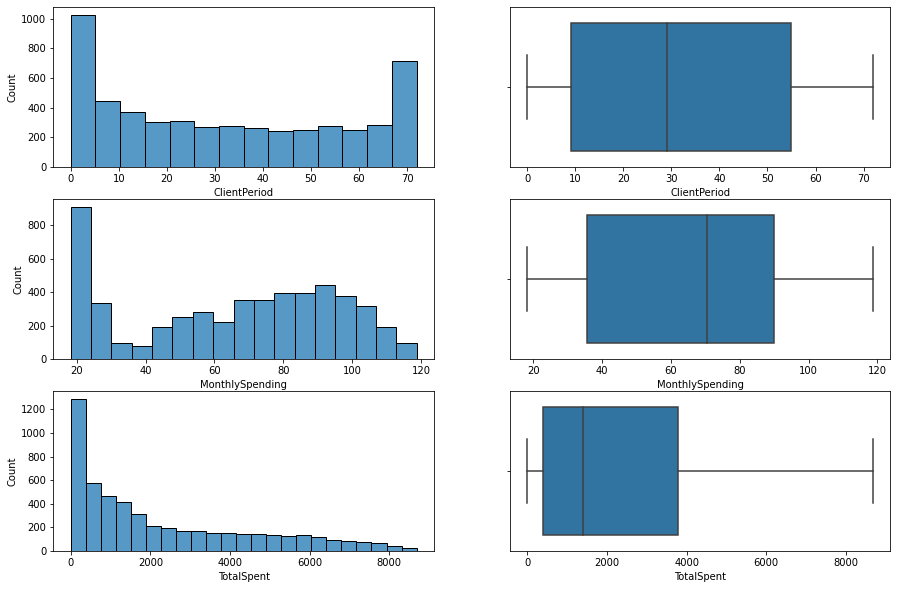

In [16]:
plot_hist_box(num_cols, data)

Так как распределение далеко от нормального(есть пики у 0) - к этим числовым признакам можно попробовать применить лог-трансформацию (см.далее)

In [17]:
# функция для построения графиков barplot

def plot_bar(cols, data):
  fig, axes = plt.subplots(figsize=(15, 30))
  counter = 1 #порядковый номер графика
  for col in cols:
    ax = plt.subplot(8, 2, counter)
    sns.countplot(x=data[col])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8) 
    for p in ax.patches: # показ количества уникальных значений (вместо таблицы value counts)
      ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='center', color='white', size=14)  
    counter += 1
  plt.show();

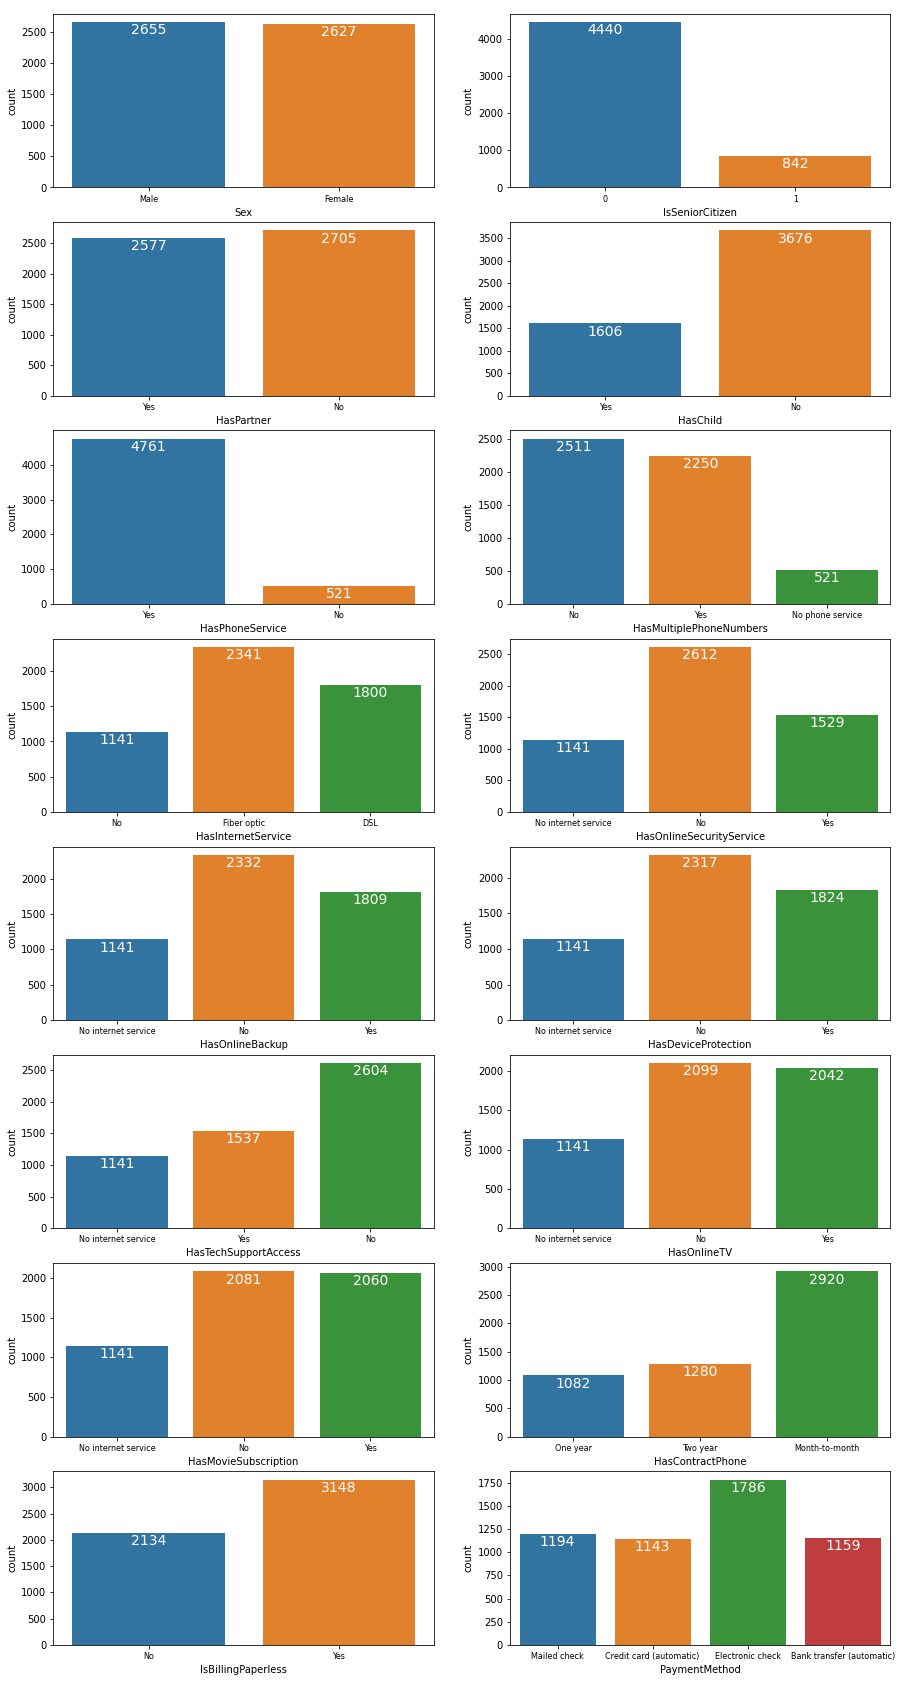

In [18]:
plot_bar(cat_cols, data)

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [19]:
# проверка на дубликаты 
data.duplicated().sum()

14

In [20]:
# убираем дубликаты
data.drop_duplicates(inplace=True)

Многие из категориальных признаков бинарные, их можно выделить в отдельную группу и преобразовать 

In [21]:
# числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# бинарные признаки 
bin_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService'
]
# категориальные признаки
cat_cols = [
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + bin_cols + cat_cols
target_col = 'Churn'

In [22]:
# трансформация бинарных признаков
data['Sex'] = data['Sex'].map({'Female':0, 'Male':1})
test['Sex'] = test['Sex'].map({'Female':0, 'Male':1})
col_dict = {'Yes':1, 'No':0}
data['HasPartner'] = data['HasPartner'].map(col_dict)
test['HasPartner'] = test['HasPartner'].map(col_dict)
data['HasChild'] = data['HasChild'].map(col_dict)
test['HasChild'] = test['HasChild'].map(col_dict)
data['HasPhoneService'] = data['HasPhoneService'].map(col_dict)
test['HasPhoneService'] = test['HasPhoneService'].map(col_dict)

In [23]:
# лог-трансформация смещенных числовых признаков и визуализация результата на трейновом и тестовом сете

def log_transform(data, cols):
  for col in cols:
    data[col] = data[col].apply(lambda x: np.log(x + 1))
    sns.histplot(x=data[col])
    plt.show()

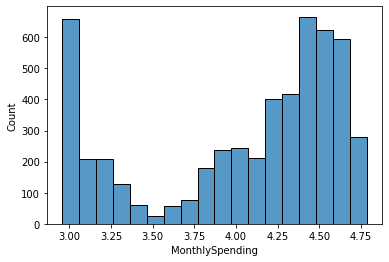

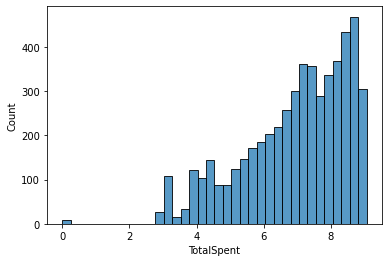

In [24]:
log_transform(data, num_cols[1:])

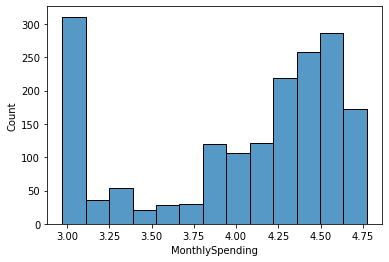

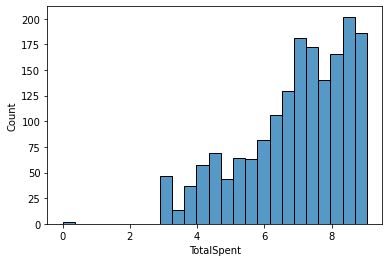

In [25]:
log_transform(test, num_cols[1:])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,Churn
ClientPeriod,1.000000,0.198728,0.828273,0.006861,0.010775,0.368264,0.144271,0.014449,-0.348881
MonthlySpending,0.198728,1.000000,0.542305,-0.012748,0.213737,0.064485,-0.137745,0.184453,0.205071
TotalSpent,0.828273,0.542305,1.000000,-0.004869,0.099637,0.310742,0.064032,0.084381,-0.230139
Sex,0.006861,-0.012748,-0.004869,1.000000,0.013915,0.003145,0.014875,-0.007903,-0.008120
IsSeniorCitizen,0.010775,0.213737,0.099637,0.013915,1.000000,0.016173,-0.217715,0.008982,0.157751
HasPartner,0.368264,0.064485,0.310742,0.003145,0.016173,1.000000,0.441631,0.002370,-0.146275
HasChild,0.144271,-0.137745,0.064032,0.014875,-0.217715,0.441631,1.000000,-0.009901,-0.162353
HasPhoneService,0.014449,0.184453,0.084381,-0.007903,0.008982,0.002370,-0.009901,1.000000,0.009974
Churn,-0.348881,0.205071,-0.230139,-0.008120,0.157751,-0.146275,-0.162353,0.009974,1.000000


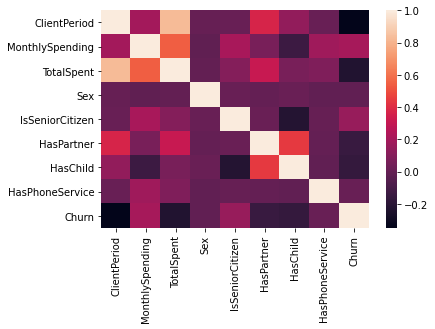

In [26]:
sns.heatmap(data[num_cols + bin_cols + [target_col]].corr()); # корреляция пирсона для числовых признаков 
data.corr()

In [27]:
# визуализация корреляции категориальных признаков
def plot_target_corr_bar(cols, data):
  fig, axes = plt.subplots(figsize=(15, 30))
  counter = 1
  for col in cols:
    ax = plt.subplot(8, 2, counter)
    sns.countplot(x=data[col], hue=data['Churn'])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    counter += 1
  plt.show();

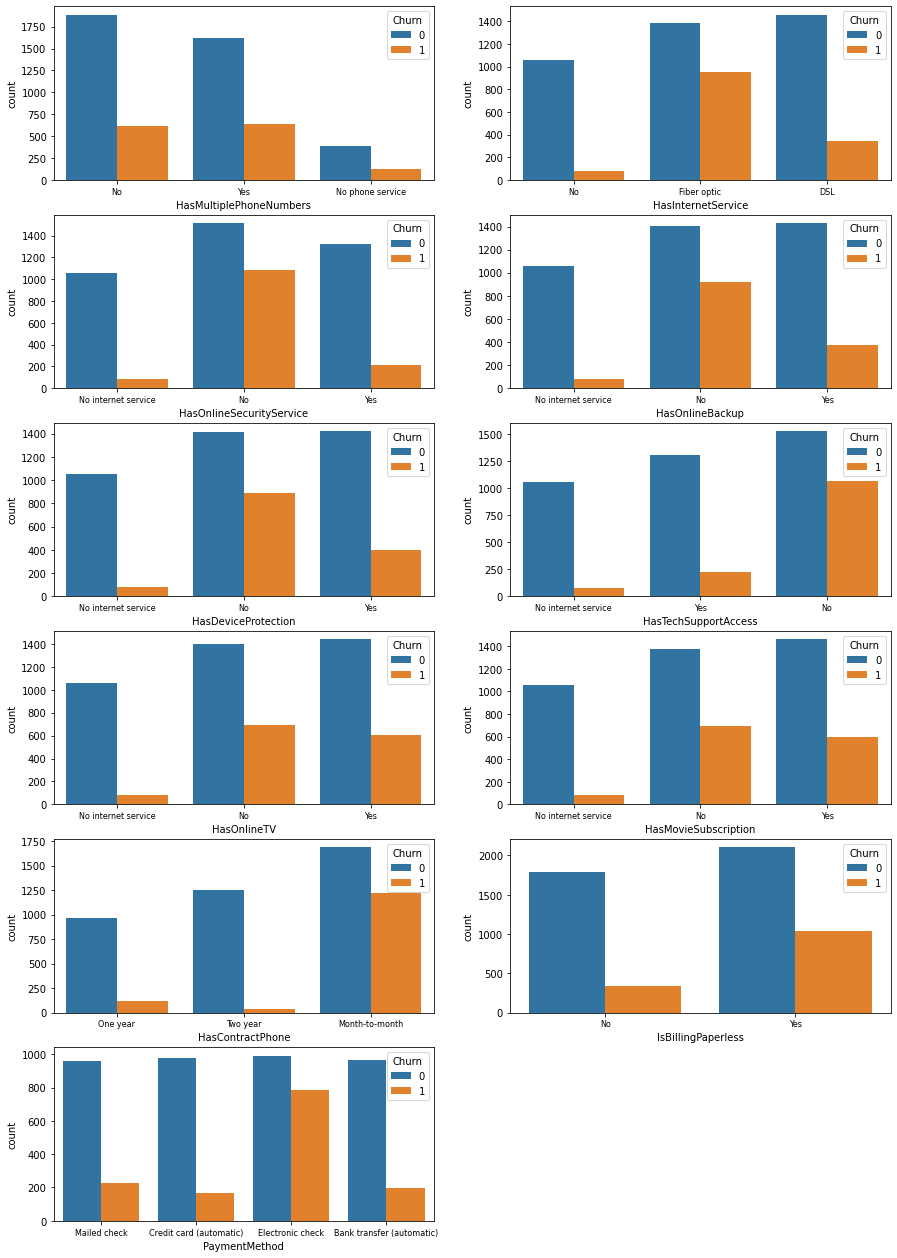

In [28]:
plot_target_corr_bar(cat_cols, data)

0    3894
1    1374
Name: Churn, dtype: int64

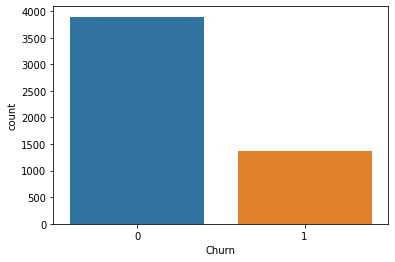

In [29]:
# соотношение классов несбалансированное

sns.countplot(x=data['Churn']);
data['Churn'].value_counts()

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [31]:
# пайплайн с логистическое регрессией
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())]) #нормализация признаков
categorical_transformer = Pipeline(steps=[('cat_encoder', OneHotEncoder())]) #кодирование категориальных


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegressionCV(max_iter=10000, scoring='roc_auc', refit=True, random_state=14))])

In [32]:
X = data.iloc[:, :-1]
y = data['Churn']

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict_proba(X_train)[:, 1]
y_valid_predicted = pipeline.predict_proba(X_valid)[:, 1]


In [35]:
y_pred = pipeline.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_pred)

0.850358864340532

In [36]:
# функция для визуализации feature importance

def plot_feat_importance(feature_names, coefs):
  zipped = zip(feature_names, coefs)
  df = pd.DataFrame(zipped, columns=["feature", "value"])
  df["abs_value"] = df["value"].apply(lambda x: abs(x))
  df = df.sort_values("abs_value", ascending=False)
  fig, ax = plt.subplots(1, 1, figsize=(12, 7))
  sns.barplot(x="feature",
              y="value",
              data=df.head(20),
            palette='Blues_r')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
  ax.set_title("Top 20 Features", fontsize=20)
  ax.set_ylabel("Importance", fontsize=20)
  ax.set_xlabel("Feature Name", fontsize=14);

# функция для визуализации roc_auc_curve

def plot_roc_auc_curve(y_train, y_train_predicted, y_valid, y_valid_predicted):
  train_auc = roc_auc_score(y_train, y_train_predicted)
  valid_auc = roc_auc_score(y_valid, y_valid_predicted)
  plt.figure(figsize=(10,7))
  plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
  plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
  legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
  legend_box.set_facecolor("white")
  legend_box.set_edgecolor("black")
  plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
  plt.show()

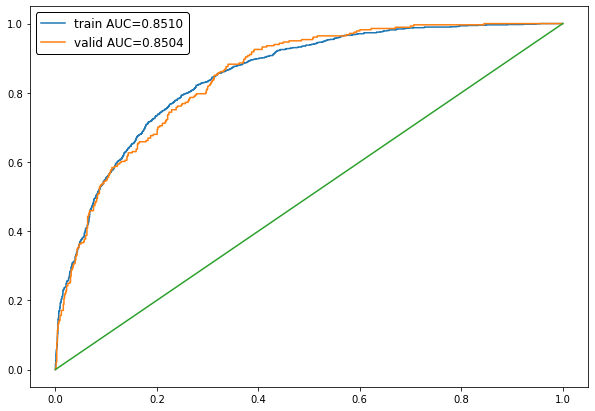

In [37]:
plot_roc_auc_curve(y_train, y_train_predicted, y_valid, y_valid_predicted)

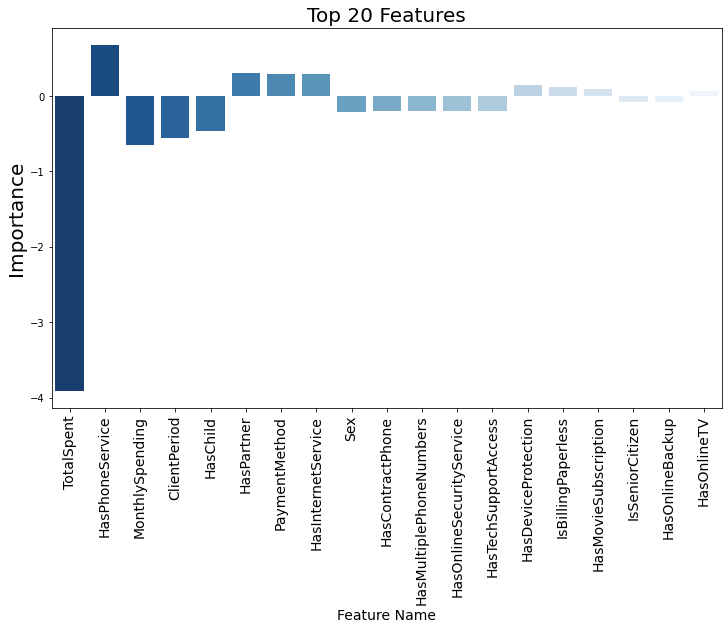

In [38]:
#коэффициенты для каждого признака
lr_feat_names = X_train.columns
lr_coefs = pipeline.named_steps["classifier"].coef_.flatten()

plot_feat_importance(lr_feat_names, lr_coefs)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

ROC_AUC score : 0.850358864340532

модель LogisticRegressionCV(C=10, остальные дефолтные параметры, увеличено только количество итераций)

4-top features - TotalSpent, HasPhoneService, MonthlySpending, ClientPeriod

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [39]:
X_train_origin, X_valid_origin, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
!pip install catboost
from catboost import CatBoostClassifier, Pool

boosting_model = CatBoostClassifier(cat_features=cat_cols, silent=True)

boosting_model.fit(X_train_origin, y_train)


     |████████████████████████████████| 67.3MB 56kB/s 


In [41]:
roc_auc_score(y_valid, boosting_model.predict_proba(X_valid)[:, 1])

0.8432161058500182

In [42]:
# подбор параметров
boosting_model = CatBoostClassifier(silent=True,
                                    cat_features=cat_cols,
                                    eval_metric='AUC:hints=skip_train~false')

catb_params = {'learning_rate': np.arange(0.01, 0.051, 0.01),
               'iterations': [200, 500, 1000, 1500]}
               
best_params = boosting_model.randomized_search(catb_params, 
                           X_train_origin, 
                           y_train,
                           verbose=False,
                           refit=True)
best_params['params']


bestTest = 0.8542241392
bestIteration = 199


bestTest = 0.84936596
bestIteration = 197


bestTest = 0.8497546143
bestIteration = 195


bestTest = 0.8520446267
bestIteration = 183


bestTest = 0.8527876423
bestIteration = 495


bestTest = 0.8559959458
bestIteration = 237


bestTest = 0.8521817988
bestIteration = 399


bestTest = 0.8532220207
bestIteration = 238


bestTest = 0.8534582616
bestIteration = 1321


bestTest = 0.8521817988
bestIteration = 399



{'iterations': 500, 'learning_rate': 0.05}

In [43]:
boosting_model = CatBoostClassifier(iterations=500,
                                    learning_rate=0.05,
                                    silent=True,
                                    cat_features=cat_cols,
                                    loss_function='Logloss',
                                    eval_metric='AUC',
                                    random_state=14)
boosting_model.fit(X_train_origin, 
                   y_train, 
                   eval_set=(X_valid_origin, y_valid),
                   use_best_model=True)

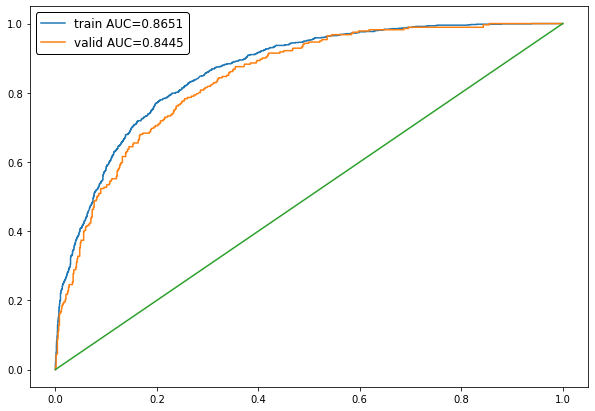

In [44]:
y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid_origin)[:, 1]

plot_roc_auc_curve(y_train, y_train_predicted, y_valid, y_valid_predicted)

In [45]:
roc_auc_score(y_valid, boosting_model.predict_proba(X_valid)[:, 1]) 

0.8445327857909057

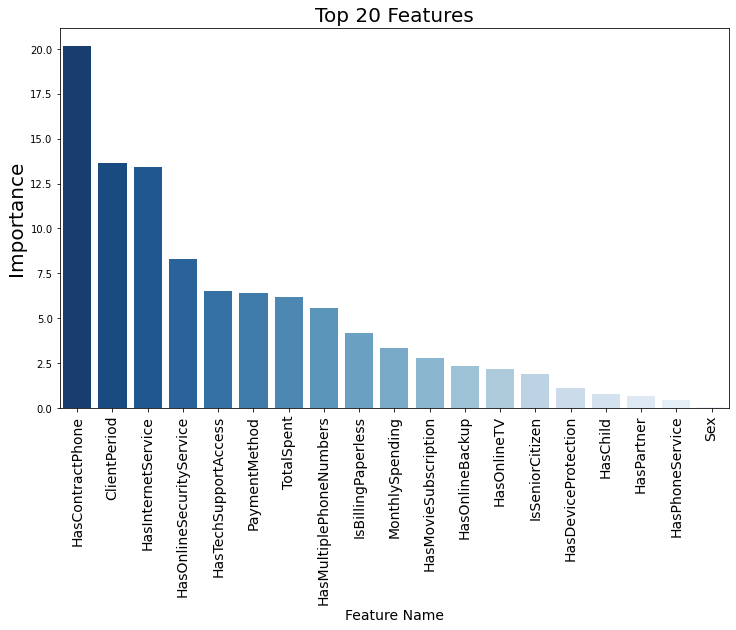

In [46]:
cat_coefs = boosting_model.feature_importances_
cat_feat_names = X_train_origin.columns

# визуализация
plot_feat_importance(cat_feat_names, cat_coefs)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

ROC_AUC score : 0.8445327857909057

модель CatBoost(500 деревьев, learning rate 0.05)

3-top features - HasContractPhone, ClientPeriod, HasInternetService

# Предсказания

In [47]:
# лучший скор показала модель логистической регрессии - проверим ее на kaggle
best_model = pipeline

In [48]:
submission['Churn'] = best_model.predict_proba(test)[:,1]
submission.set_index('Id').to_csv('/content/drive/MyDrive/DLS/my_submission_final.csv')

In [49]:
submission

,Id,Churn
0,0,0.044130
1,1,0.638967
2,2,0.668498
3,3,0.008867
4,4,0.005262
...,...,...
1756,1756,0.095814
1757,1757,0.015076
1758,1758,0.838771
1759,1759,0.626275


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

Скор на kaggle - 0.85243